<a href="https://colab.research.google.com/github/Taimaaaa/Cirrhosis-Prediction/blob/main/Copy_of_Cirrhosis_Prediction_via_Deep_ML_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cirrhosis Prediction Via Deep Learning

- Author: Taima Nasser

#Utility Functions

#Project Overview

In [128]:
# Custom EDA Toolkit
# Works for both categorical and numeric features

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Explore Categorical
# Add the print statements to the function
def explore_categorical(df, x, fillna = True, placeholder = 'MISSING',
                        figsize = (6,4), order = None):

    # Make a copy of the dataframe and fillna
    temp_df = df.copy()
    # Before filling nulls, save null value counts and percent for printing
    null_count = temp_df[x].isna().sum()
    null_perc = null_count / len(temp_df) * 100
    # fillna with placeholder
    if fillna == True:
        temp_df[x] = temp_df[x].fillna(placeholder)
    # Create figure with desired figsize
    fig, ax = plt.subplots(figsize=figsize)
    # Plotting a count plot
    sns.countplot(data=temp_df, x=x, ax=ax, order=order)
    # Rotate Tick labels for long names
    ax.tick_params(axis='x', labelrotation=45)
    plt.setp(ax.get_xticklabels(), ha='right')
    # Add a title with the feature name included
    ax.set_title(f"Column: {x}")

    # Fix layout and show plot (before print statements)
    fig.tight_layout()
    plt.show()

    # Print null value info
    print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
    # Print cardinality info
    nunique = temp_df[x].nunique()
    print(f"- Unique Values: {nunique}")
    # First find value counts of feature
    val_counts = temp_df[x].value_counts(dropna=False)
    # Define the most common value
    most_common_val = val_counts.index[0]
    # Define the frequency of the most common value
    freq = val_counts.values[0]
    # Calculate the percentage of the most common value
    perc_most_common = freq / len(temp_df) * 100
    # Print the results
    print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
    # print message if quasi-constant or constant (most common val more than 98% of data)
    if perc_most_common > 98:
        print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
    else:
        print("- Not constant or quasi-constant.")
    return fig, ax



# Plot Categorical vs Target
# Updating function
def plot_categorical_vs_target(df, x, y, figsize=(6,4),
                               fillna=True, placeholder='MISSING',
                               order=None, target_type='reg'):
    # Make a copy of the dataframe and fillna
    temp_df = df.copy()

    # fillna with placeholder
    if fillna == True:
        temp_df[x] = temp_df[x].fillna(placeholder)
    # or drop nulls to prevent unwanted 'nan' group in stripplot
    else:
        temp_df = temp_df.dropna(subset=[x])

    # Create the figure and subplots
    fig, ax = plt.subplots(figsize=figsize)

    # REGRESSION - TARGET PLOT
    if target_type == 'reg':  # Added if statement here
        # Barplot
        sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order,
                    alpha=0.6, linewidth=1, edgecolor='black',
                    errorbar=None)
        # Stripplot
        sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax,
                      order=order, hue_order=order, legend=False,
                      edgecolor='white', linewidth=0.5,
                      size=3, zorder=6)

    # CLASSIFICATION - TARGET PLOT
    elif target_type == 'class':
        ax = sns.histplot(data=temp_df, hue=y, x=x,
                          stat='percent', multiple='fill')

    # Rotate xlabels
    ax.set_xticks(ax.get_xticks())  # Prevent a bug
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    # Add a title
    ax.set_title(f"{x} vs. {y}")
    fig.tight_layout()

    return fig, ax



# Explore Numeric
def explore_numeric(df, x, figsize=(6,5)):
    gridspec = {'height_ratios': [0.7, 0.3]}
    fig, axes = plt.subplots(nrows=2, figsize=figsize,
                             sharex=True, gridspec_kw=gridspec)

    sns.histplot(data=df, x=x, ax=axes[0])
    sns.boxplot(data=df, x=x, ax=axes[1])
    axes[0].set_title(f"Column: {x}", fontweight='bold')
    fig.tight_layout()
    plt.show()

    null_count = df[x].isna().sum()
    null_perc = null_count / len(df) * 100
    print(f"— NaN's Found: {null_count} ({round(null_perc, 2)}%)")

    unique_vals = df[x].nunique()
    print(f"— Unique Values: {unique_vals}")

    # Get the most common value(s)
    most_common_val_count = df[x].value_counts(dropna=False).head(1)
    most_common_val = most_common_val_count.index[0]
    freq = most_common_val_count.values[0]
    perc_most_common = freq / len(df) * 100

    print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")

  # print message if quasi-constant or constant (most common val more than 98% of data)
    if perc_most_common > 98:
      print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
    else:
      print("- Not constant or quasi-constant.")
      return fig, axes




# Plot Numeric vs Target
# Updating the function
# Updating the function
def plot_numeric_vs_target(df, x, y, figsize=(6,4),
                           target_type='reg', estimator='mean',
                           errorbar='ci', sorted=False, ascending=False,
                           **kwargs):  # kwargs for sns.regplot

    # Handle null values
    nulls = df[[x,y]].isna().sum()
    if nulls.sum() > 0:
        print(f"- Excluding {nulls.sum()} NaN's")
        temp_df = df.dropna(subset=[x,y])
    else:
        temp_df = df

    # Create the figure
    fig, ax = plt.subplots(figsize=figsize)

    # REGRESSION – TARGET PLOT
    if target_type == 'reg':
        # Calculate correlation
        corr = df[[x,y]].corr().round(2)
        r = corr.loc[x,y]

        # Plot regression with scatter
        scatter_kws = {'ec':'white','lw':1,'alpha':0.6}
        sns.regplot(data=temp_df, x=x, y=y, ax=ax,
                    scatter_kws=scatter_kws, **kwargs)

        # Add correlation in title
        ax.set_title(f"{x} vs. {y} (r = {r})")
      # CLASSIFICATION – TARGET PLOT
    elif target_type == 'class':
        # Sort groups if required
        if sorted:
          if estimator == 'median':
            group_vals = temp_df.groupby(y)[x].median()
          elif estimator =='mean':
              group_vals = temp_df.groupby(y)[x].mean()

          ## Sort values
          group_vals = group_vals.sort_values(ascending=ascending)
          order = group_vals.index
        else:
              # Set order to None if not calcualted
              order = None

          # Left Subplot (barplot)
        sns.barplot(data=temp_df, x=y, y=x, order=order, estimator=estimator,
                      errorbar=errorbar, ax=ax, **kwargs)

          # Add title
        ax.set_title(f"{x} vs. {y}")

          # rotate xaxis labels
        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

          # Final Adjustments & return
        fig.tight_layout()
        fig.show()
        return fig, ax



from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def regression_metrics(y_true, y_pred, label='', verbose=True, output_dict=False):
    # Get metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = rmse = sqrt(mse)
    r_squared = r2_score(y_true, y_pred)

    if verbose == True:
        # Print Result with Label and Header
        header = "-"*60
        print(header, f"Regression Metrics: {label}", header, sep='\n')
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")

    if output_dict == True:
        metrics = {
            'Label': label,
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'R^2': r_squared
        }
        return metrics


def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose=True, output_frame=False):
    # Get predictions for training data
    y_train_pred = reg.predict(X_train)
    # Call the helper function to obtain regression metrics for training data
    results_train = regression_metrics(
        y_train, y_train_pred,
        verbose=verbose, output_dict=output_frame,
        label='Training Data'
    )

    print()

    # Get predictions for test data
    y_test_pred = reg.predict(X_test)
    # Call the helper function to obtain regression metrics for test data
    results_test = regression_metrics(
        y_test, y_test_pred,
        verbose=verbose, output_dict=output_frame,
        label='Test Data'
    )

    # Store results in a dataframe if ouput_frame is True
    if output_frame:
        results_df = pd.DataFrame([results_train, results_test])
        # Set the label as the index
        results_df = results_df.set_index('Label')
        # Set index.name to none to get a cleaner looking result
        results_df.index.name = None
        # Return the dataframe
        return results_df.round(3)

from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

def classification_metrics(y_true, y_pred, label="",
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
    # Get the classification report (string version)
    report = classification_report(y_true, y_pred)

    # Print header and report
    header = "-"*76
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)

    # Create confusion matrix plots side by side
    fig, axes = plt.subplots(ncols=2, figsize=figsize)

    # Raw counts confusion matrix
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None, cmap='gist_gray',
                                            colorbar=colorbar, ax=axes[0])
    axes[0].set_title("Raw Counts")

    # Normalized confusion matrix
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize, cmap=cmap,
                                            colorbar=colorbar, ax=axes[1])
    axes[1].set_title("Normalized Confusion Matrix")

    # Layout
    fig.tight_layout()
    plt.show()

    # Return dictionary of classification_report (optional)
    if output_dict:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict

def evaluate_classification(model, X_train, y_train, X_test, y_test,
                            figsize=(6,4), normalize='true',
                            output_dict=False,
                            cmap_train='Blues', cmap_test='Reds',
                            colorbar=False):
    # Get predictions for training data
    y_train_pred = model.predict(X_train)
    results_train = classification_metrics(y_train, y_train_pred,
                                           output_dict=True, figsize=figsize,
                                           colorbar=colorbar, cmap=cmap_train,
                                           label='Training Data')

    print()  # Line break for readability

    # Get predictions for test data
    y_test_pred = model.predict(X_test)
    results_test = classification_metrics(y_test, y_test_pred,
                                          output_dict=True, figsize=figsize,
                                          colorbar=colorbar, cmap=cmap_test,
                                          label='Test Data')

    # Return results as dictionary if requested
    if output_dict:
        results_dict = {'train': results_train,
                        'test': results_test}
        return results_dict


# --- Function 1: Extract coefficients from Linear Regression ---
def get_coeffs_linreg(lin_reg, feature_names=None, sort=True, ascending=True,
                      name='LinearRegression Coefficients'):
    if feature_names is None:
        feature_names = lin_reg.feature_names_in_
    coeffs = pd.Series(lin_reg.coef_, index=feature_names, name=name)
    coeffs['intercept'] = lin_reg.intercept_
    if sort:
        coeffs = coeffs.sort_values(ascending=ascending)
    return coeffs

# --- Function 2: Plot top N coefficients ---
def plot_coeffs(coeffs, top_n=None, figsize=(6,6),
                intercept=False, intercept_name='intercept',
                annotate=False, ha='left', va='center', size=10,
                xytext=(4,0), textcoords='offset points'):
    # Drop intercept
    if not intercept and intercept_name in coeffs.index:
        coeffs = coeffs.drop(intercept_name)

    # Determine which coefficients to show
    if top_n is None:
        plot_vals = coeffs.sort_values()
        title = "All Coefficients Ranked by Magnitude"
    else:
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        title = f"Top {top_n} Largest Coefficients"

    # Plot
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', ylabel='Feature Names', title=title)
    ax.axvline(0, color='k')

    if annotate:
        for i, v in enumerate(plot_vals):
            ax.text(v, i, f'{v:.2f}', va=va, ha=ha, size=size,
                    xytext=xytext, textcoords=textcoords)
    return ax


# Custom function for plotting each metric
def plot_history(history, figsize=(6,12), marker='o'):

    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]

    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics), figsize=figsize)

    # For each metric
    for i, metric_name in enumerate(metrics):

        # Get the axis for the current metric
        ax = axes[i]

        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch

        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)

        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs, metric_values, label=val_metric_name, marker=marker)

        # Final subplot adjustments
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes
# Build and Compile Model within a function to try optimizer, units, and dropout
def build_model(hp):
    # Instantiate model
    model = Sequential()

    # First hidden layer (fixed)
    model.add(Dense(19,
                    input_dim=input_shape,
                    activation='relu'))

    # Tunable units for second hidden layer
    model.add(Dense(
        units=hp.Int('units', min_value=10, max_value=50, step=5),
        activation='relu'
    ))

    # Tunable dropout rate
    model.add(Dropout(
        hp.Float('dropout_value', min_value=0.0, max_value=0.5, step=0.1)
    ))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Tunable optimizer
    model.compile(optimizer=hp.Choice('optimizer',
                                      ['rmsprop', 'nadam', 'adam']),
                  loss='bce',
                  metrics=['accuracy',
                           tf.keras.metrics.Recall(name='recall'),
                           tf.keras.metrics.Precision(name='precision')])

    return model




**Data Dictionary**


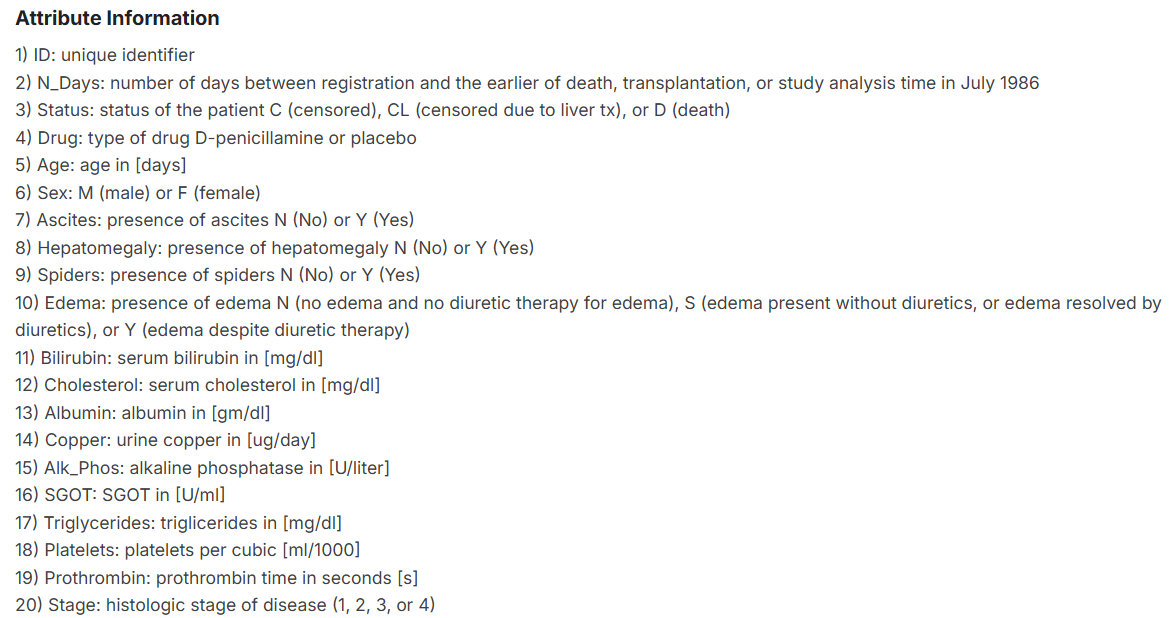

# Load and Inspect Data

In [129]:
#importing pandas and reading file
import pandas as pd
import numpy as np
import matplotlib.font_manager as fm
from math import pi


In [130]:
import kagglehub
import os

# Download latest version
fpath = kagglehub.dataset_download("fedesoriano/cirrhosis-prediction-dataset")

# Get the actual CSV file path
csv_path = os.path.join(fpath, "cirrhosis.csv")

# Read the CSV file
df = pd.read_csv(csv_path)


Using Colab cache for faster access to the 'cirrhosis-prediction-dataset' dataset.


In [131]:
df.head()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             418 non-null    int64  
 1   N_Days         418 non-null    int64  
 2   Status         418 non-null    object 
 3   Drug           312 non-null    object 
 4   Age            418 non-null    int64  
 5   Sex            418 non-null    object 
 6   Ascites        312 non-null    object 
 7   Hepatomegaly   312 non-null    object 
 8   Spiders        312 non-null    object 
 9   Edema          418 non-null    object 
 10  Bilirubin      418 non-null    float64
 11  Cholesterol    284 non-null    float64
 12  Albumin        418 non-null    float64
 13  Copper         310 non-null    float64
 14  Alk_Phos       312 non-null    float64
 15  SGOT           312 non-null    float64
 16  Tryglicerides  282 non-null    float64
 17  Platelets      407 non-null    float64
 18  Prothrombi

## Clean Data

In [133]:
# How many rows/columns
df.shape

(418, 20)

*   There are 418 rows & 20 columns


In [134]:
# What are the datatypes of each variable?
df.dtypes

,0
ID,int64
N_Days,int64
Status,object
Drug,object
Age,int64
Sex,object
Ascites,object
Hepatomegaly,object
Spiders,object
Edema,object


In [135]:
#Dropping ID column
df = df.drop('ID', axis=1)

In [136]:
# Are there duplicates? If so, drop any duplicates.
df.duplicated().sum()

np.int64(0)

* There are no duplicates



In [137]:
# Identify missing values.
df.isna().sum()

,0
N_Days,0
Status,0
Drug,106
Age,0
Sex,0
Ascites,106
Hepatomegaly,106
Spiders,106
Edema,0
Bilirubin,0


* We can see that several features have missing values, i will deal with them via Simple Imputer

In [138]:
df['Stage'] = df['Stage'].fillna(df['Stage'].mode()[0])


In [139]:
# Find and fix any inconsistent categories of data (for example: fixing cat, Cat, and cats so that they are consistent).
# Starting by creating objects columns dataframe
cat_cols=df.select_dtypes("object").columns
cat_cols

Index(['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], dtype='object')

In [140]:
#then looping through all objects and seeing where inconsistencies lie
for col in cat_cols:
  print (f"Counts for {col}")
  print (df[col].value_counts() )
  print( "\n" )

Counts for Status
Status
C     232
D     161
CL     25
Name: count, dtype: int64


Counts for Drug
Drug
D-penicillamine    158
Placebo            154
Name: count, dtype: int64


Counts for Sex
Sex
F    374
M     44
Name: count, dtype: int64


Counts for Ascites
Ascites
N    288
Y     24
Name: count, dtype: int64


Counts for Hepatomegaly
Hepatomegaly
Y    160
N    152
Name: count, dtype: int64


Counts for Spiders
Spiders
N    222
Y     90
Name: count, dtype: int64


Counts for Edema
Edema
N    354
S     44
Y     20
Name: count, dtype: int64




* All fixed!

In [141]:
# For any numerical columns, obtain the summary statistics of each (min, max. mean).
sum_stats =  df.describe()
sum_stats.loc[['mean','min','max']]

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
mean,1917.782297,18533.351675,3.220813,369.510563,3.49744,97.648387,1982.655769,122.556346,124.702128,257.02457,10.731731,3.023923
min,41.000000,9598.000000,0.300000,120.000000,1.96000,4.000000,289.000000,26.350000,33.000000,62.00000,9.000000,1.000000
max,4795.000000,28650.000000,28.000000,1775.000000,4.64000,588.000000,13862.400000,457.250000,598.000000,721.00000,18.000000,4.000000


# Exploratory Data Analysis

We should first check our target sanity: how skewed is it or if any extremes are found.

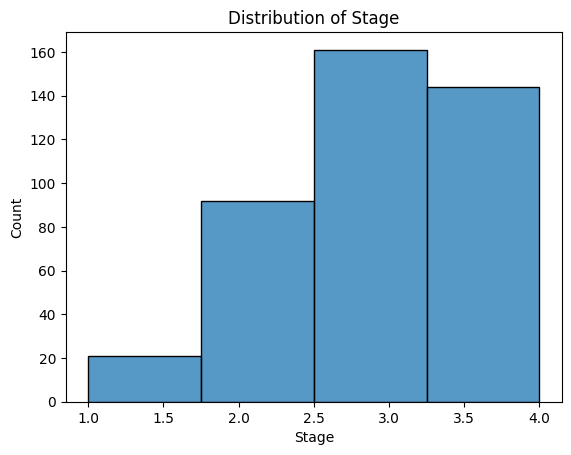

In [142]:
# 1. Histogram of Stage
sns.histplot(data=df, x="Stage", bins=4)
plt.title("Distribution of Stage")
plt.xlabel("Stage")
plt.ylabel("Count");

Interpretation: The histogram shows the distribution of patients across the four disease stages.
It’s clear that the data is not evenly distributed — most patients are in Stage 3, followed by Stage 4, while Stage 1 has very few cases.
This indicates a mild class imbalance, meaning advanced stages are more common in the dataset, which could affect model training if the target is Stage.


#Numerical Features

## Numerical Features Correlation

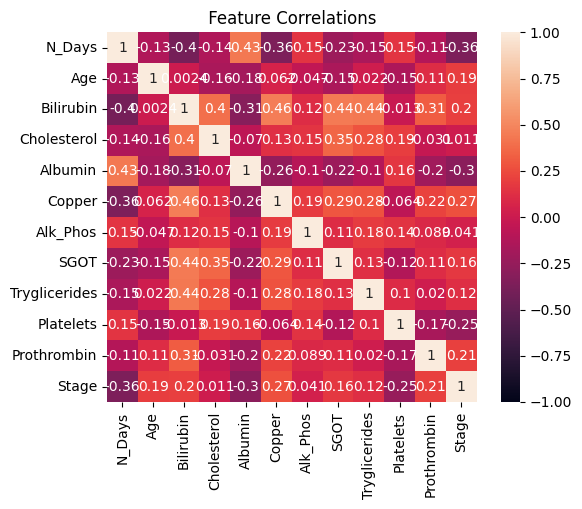

In [143]:
#use heatmap for correlation factor between the features.
num_cols = ["N_Days",	"Age",	"Bilirubin",	"Cholesterol",	"Albumin",	"Copper",	"Alk_Phos",	"SGOT",	"Tryglicerides",	"Platelets",	"Prothrombin",	"Stage"]
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, square=True)
plt.title( ' Feature Correlations ' );
plt.show()

Interpretation:
- Albumin and N_Days have a negative correlation with Stage (around –0.3 to –0.4), meaning lower albumin levels and shorter survival times are associated with more advanced disease stages.
- Bilirubin, Copper, and Prothrombin have positive correlations with Stage (around 0.2), suggesting that higher values tend to occur in later stages.

- Most biochemical features (like Cholesterol, Alk_Phos, SGOT, Triglycerides) show weak or no correlation with Stage.

- There are moderate relationships between Bilirubin–Albumin (–0.43) and Bilirubin–SGOT (0.44), indicating potential interactions between liver function indicators.
Overall, the plot suggests that **Albumin, Bilirubin, N_Days, and Copper** are among the most informative features related to disease progression.

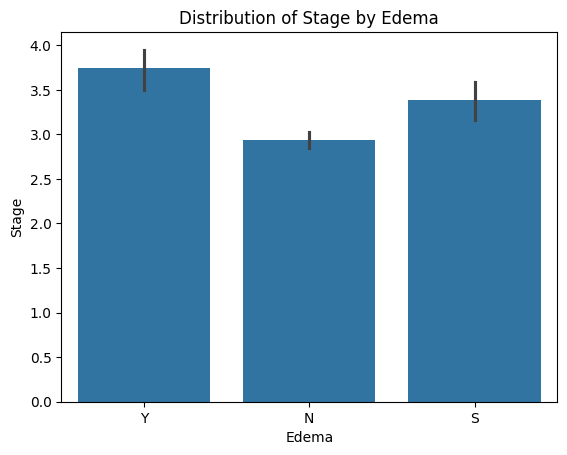

In [144]:
ax = sns.barplot(data=df, x="Edema", y="Stage")
ax.set_title("Distribution of Stage by Edema")
plt.show()

Interpretation:
- Patients with Edema = Y (persistent edema despite treatment) have the highest average disease stage, indicating more severe liver disease.
- Those with Edema = S (edema resolved or mild) have slightly lower stages, while Edema = N (no edema) corresponds to the lowest average stage.
- This trend suggests that the presence and severity of edema are strongly associated with advanced liver disease.

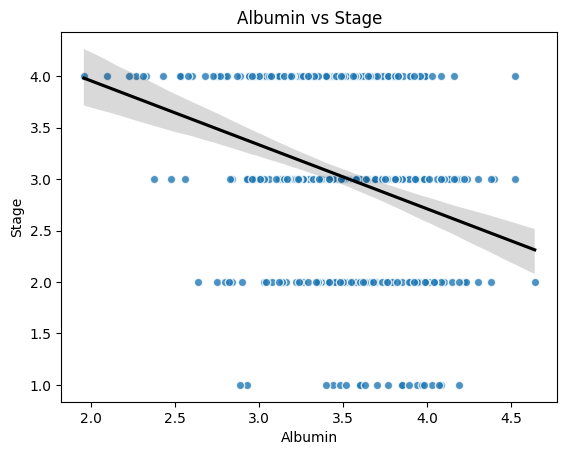

In [145]:
scatter_kws = dict(edgecolor="white")
line_kws = dict(color="black")
sns.regplot(data=df, x='Albumin', y='Stage', scatter_kws=scatter_kws, line_kws=line_kws);
plt.title('Albumin vs Stage');


Interpretation:
- There is a clear negative correlation — as Albumin levels decrease, the disease stage increases.This means patients with lower Albumin (a sign of reduced liver function) tend to be in more advanced stages of cirrhosis.
- The trend line and shaded confidence interval confirm that this relationship is strong and consistent.

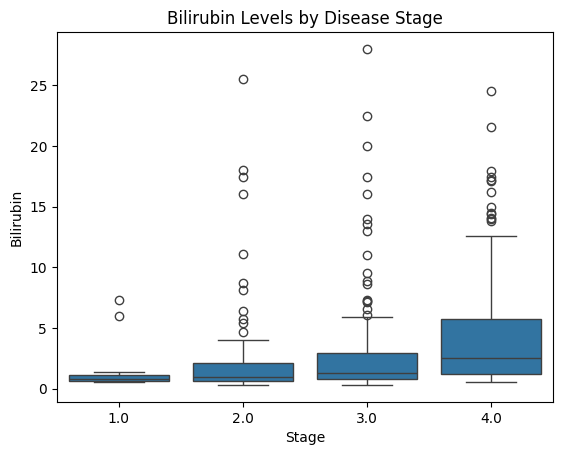

In [146]:
# Boxplot: Bilirubin vs Stage
sns.boxplot(data=df, x="Stage", y="Bilirubin")
plt.title("Bilirubin Levels by Disease Stage");


Interpretation:
- This boxplot shows how serum bilirubin levels vary across the four cirrhosis stages.
- As the stage increases, bilirubin levels tend to rise noticeably, with Stage 4 patients showing the highest median and widest range.
This pattern indicates that higher bilirubin values are associated with more advanced liver disease, which aligns with medical expectations since bilirubin reflects liver function deterioration.

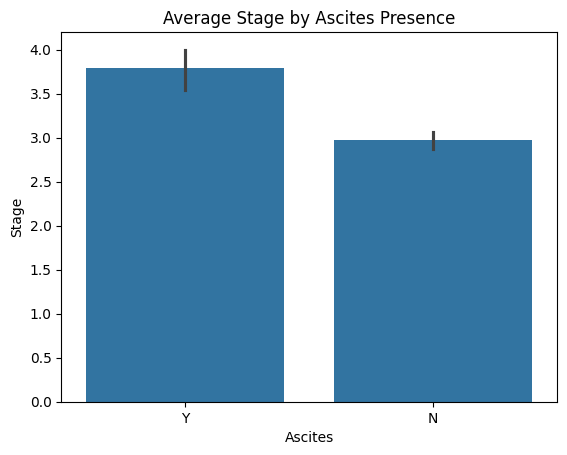

In [147]:
# Barplot: Ascites vs Stage
sns.barplot(data=df, x="Ascites", y="Stage")
plt.title("Average Stage by Ascites Presence");


This bar plot compares the average disease stage between patients with (Y) and without (N) ascites.
Patients who have ascites generally fall into a higher average stage, while those without ascites are in earlier stages.
This suggests that the presence of ascites is a strong indicator of severe liver damage.

# Preprocessing and Machine Model

##imports for preprocessing


In [148]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn import set_config
set_config(transform_output='pandas')

Define features (X) and target (y).

In [149]:
# Define features (X) and target (y).
target = 'Stage'
X = df.drop(columns="Stage")
y = df[target]

Train test split the data to prepare for machine learning.

In [150]:
# Train 70%, Temp 30%
X_train_raw, X_temp_raw, y_train_raw, y_temp_raw = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# From Temp: 15% validation, 15% test
X_val_raw, X_test_raw, y_val_raw, y_test_raw = train_test_split(
    X_temp_raw, y_temp_raw, test_size=0.5, random_state=42
)


Identify each feature as numerical, ordinal, or nominal.

In [151]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 313 entries, 132 to 102
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         313 non-null    int64  
 1   Status         313 non-null    object 
 2   Drug           243 non-null    object 
 3   Age            313 non-null    int64  
 4   Sex            313 non-null    object 
 5   Ascites        243 non-null    object 
 6   Hepatomegaly   243 non-null    object 
 7   Spiders        243 non-null    object 
 8   Edema          313 non-null    object 
 9   Bilirubin      313 non-null    float64
 10  Cholesterol    220 non-null    float64
 11  Albumin        313 non-null    float64
 12  Copper         241 non-null    float64
 13  Alk_Phos       243 non-null    float64
 14  SGOT           243 non-null    float64
 15  Tryglicerides  219 non-null    float64
 16  Platelets      306 non-null    float64
 17  Prothrombin    313 non-null    float64
dtypes: float64(9)

In [152]:
# Checking object columns
X_train.select_dtypes('object')

,Status,Drug,Sex,Ascites,Hepatomegaly,Spiders,Edema
132,D,Placebo,M,N,N,N,N
60,C,Placebo,M,N,N,N,N
198,C,D-penicillamine,F,N,N,N,N
332,D,NaN,F,NaN,NaN,NaN,N
63,D,Placebo,F,N,Y,N,N
...,...,...,...,...,...,...,...
71,C,Placebo,F,N,N,N,N
106,C,Placebo,F,N,N,N,N
270,C,Placebo,F,N,Y,N,N
348,C,NaN,F,NaN,NaN,NaN,N


#### Features:

- Ordinal: Edema, Ascites, Hepatomegaly, Spiders
- Categorical: Dru, Sex
- The remaining features are numeric.

I will create 3 pipelines (one for numeric, ordinal, and categorical features).

For the numeric features/pipeline I will:

- Impute null values using SImpleImputer using the ‘mean’ strategy.
- Scale the data with StandardScaler.

For categorical (nominal) pipeline:

- Impute null values using SimpleImputer using the ‘constant’ strategy with a fill value of "MISSING."

- Use OneHotEncoder to encode the features.
  - Be sure to include the arguments: sparse_output=False AND handle_unknown='ignore' when creating the OneHotEncoder.


For the ordinal pipeline:
- Impute null values using SimpleImputer using the "most_frequent" strategy.
- Use OrdinalEncoder to encode the "Outlet_Size" column.
- Scale the ordinal features using StandardScaler

### Pipelines

In [153]:
# Prepare ordinal pipeline
ord_cols = ['Edema', 'Ascites', 'Hepatomegaly', 'Spiders']

# Impute Most common
impute_common = SimpleImputer(strategy='most_frequent')

ord_categories = [
    ['N', 'S', 'Y'],  # Edema
    ['N', 'Y'],       # Ascites
    ['N', 'Y'],       # Hepatomegaly
    ['N', 'Y']        # Spiders
]

ord_encoder = OrdinalEncoder(categories=ord_categories)
scaler = StandardScaler()

ord_pipe = make_pipeline(impute_common, ord_encoder, scaler)
ord_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['N', 'S', 'Y'], ['N', 'Y'],
                                            ['N', 'Y'], ['N', 'Y']])),
                ('standardscaler', StandardScaler())])

In [154]:
# Prepare Categorical pipeline
cat_cols = X_train.select_dtypes('object').drop(columns=ord_cols).columns

impute_missing = SimpleImputer(strategy='constant',fill_value='MISSING')
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe_pipe = make_pipeline(impute_missing, ohe_encoder)
ohe_pipe

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='MISSING', strategy='constant')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [155]:
# Prepare numeric piepline
num_cols = X_train.select_dtypes('number').columns

mean_imputer = SimpleImputer(strategy="mean")
scaler = StandardScaler()

#Numeric Pipeline
numeric_pipe = make_pipeline(mean_imputer, scaler)
numeric_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

### ColumnTransformer

Create a tuple for each pipeline

In [156]:
#tuple= (name, pipeline, feature_list).
num_tuple = ('numeric', numeric_pipe, num_cols)
ohe_tuple = ('categorical', ohe_pipe, cat_cols)
ord_tuple = ('ordinal', ord_pipe, ord_cols)

Instantiate ColumnTransformer with all tuples.

In [157]:
col_transformer = ColumnTransformer(
    [num_tuple, ord_tuple, ohe_tuple],
    verbose_feature_names_out=False
)

Fit on training data only.

In [158]:
col_transformer.fit(X_train)



ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin'],
      dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_f...
                                                                              'Y']])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Edema', 'Ascites', 'Hepatomegaly',
                                  'Spiders']),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Status', 'Drug', 'Sex'], dtype='object'))],
                  verbose_feature_names_out=False)

Transform training, val and test data.

In [159]:
X_train_processed = col_transformer.fit_transform(X_train_raw)
X_val_processed   = col_transformer.transform(X_val_raw)
X_test_processed  = col_transformer.transform(X_test_raw)


In [160]:
#checking class imbalance
y.value_counts(normalize=True)


,proportion
Stage,
3.0,0.385167
4.0,0.344498
2.0,0.220096
1.0,0.050239


In [161]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(
    X_train_processed, y_train_raw
)

In [162]:
from sklearn.preprocessing import LabelEncoder
label_enc = LabelEncoder()
label_enc.fit(y_train_balanced)

y_train_enc = label_enc.transform(y_train_balanced)
y_val_enc   = label_enc.transform(y_val_raw)
y_test_enc  = label_enc.transform(y_test_raw)


In [163]:
from sklearn.preprocessing import LabelBinarizer
binarizer = LabelBinarizer()
binarizer.fit(y_train_enc)

y_train_bin = binarizer.transform(y_train_enc)
y_val_bin   = binarizer.transform(y_val_enc)
y_test_bin  = binarizer.transform(y_test_enc)

In [164]:
import numpy as np

X_train_balanced = np.array(X_train_balanced)
X_val_processed  = np.array(X_val_processed)
X_test_processed = np.array(X_test_processed)

# Shapes needed for ANN
input_shape = X_train_balanced.shape[1]
num_classes = y_train_bin.shape[1]

#Deep Learning: Neural Network Model

In [165]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

In [166]:
#building baseline model
def build_baseline_model():
    model = Sequential()

    # One hidden layer
    model.add(Dense(64, activation="relu", input_dim=input_shape))

    # Dropout
    model.add(Dropout(0.2))

    # Output layer for MULTICLASS (4 classes)
    model.add(Dense(num_classes, activation="softmax"))

    # Compile model
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

baseline_model = build_baseline_model()
baseline_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,796 (7.02 KB)

 Trainable params: 1,796 (7.02 KB)

 Non-trainable params: 0 (0.00 B)

In [167]:
#early stopping
early_stop = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True
)

In [168]:
# training model (50 epochs)

history_baseline = baseline_model.fit(
    X_train_balanced,
    y_train_bin,
    validation_data=(X_val_processed, y_val_bin),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

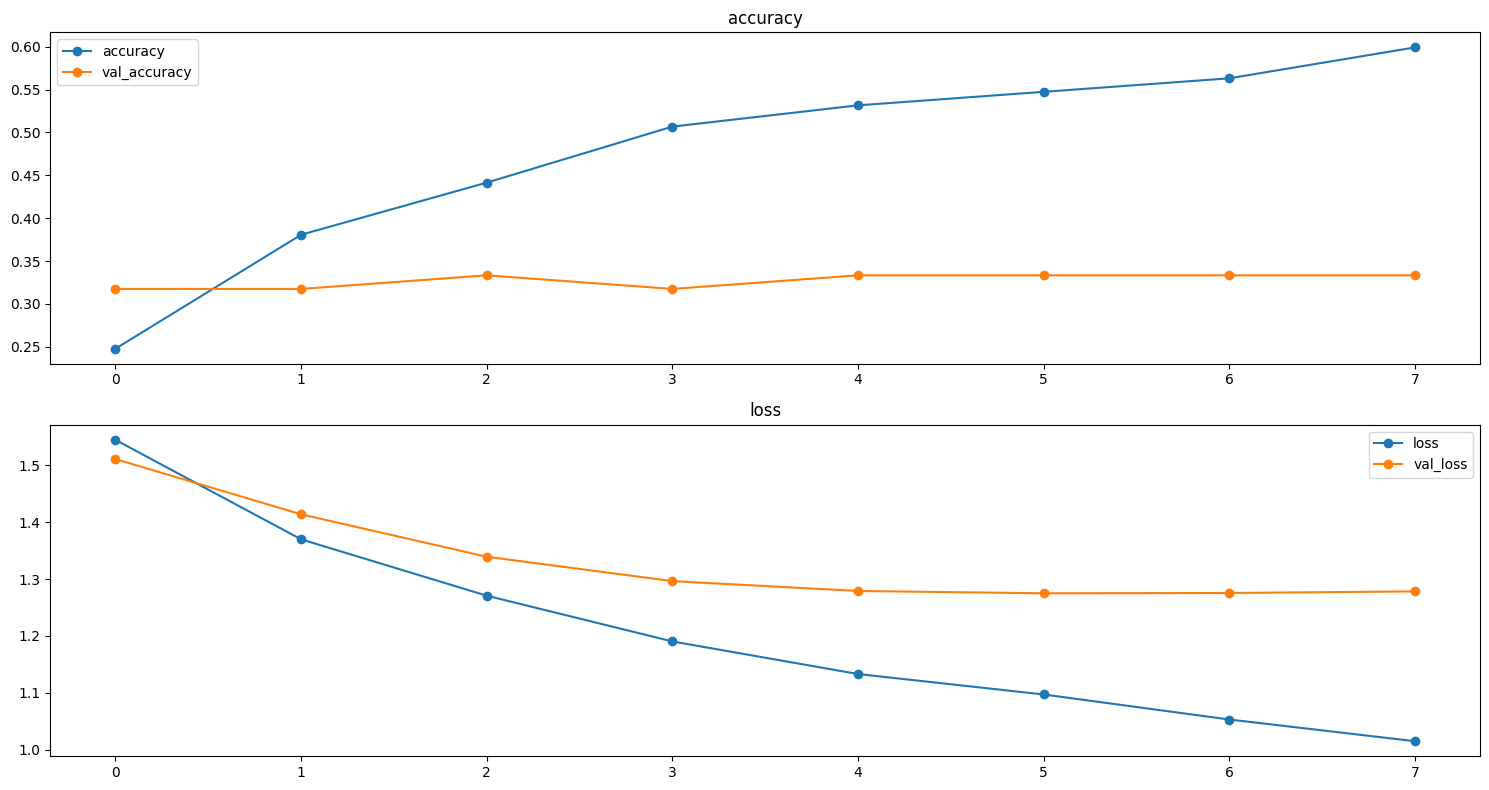

In [171]:
fig, axes = plot_history(
    history_baseline,
    figsize=(15,8),
    marker='o'
)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
----------------------------------------------------------------------------
 Classification Metrics: Baseline Neural Network (Test Set)
----------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.06      0.11      0.07         9
           2       0.31      0.16      0.21        31
           3       0.63      0.55      0.59        22

    accuracy                           0.29        63
   macro avg       0.25      0.20      0.22        63
weighted avg       0.38      0.29      0.32        63



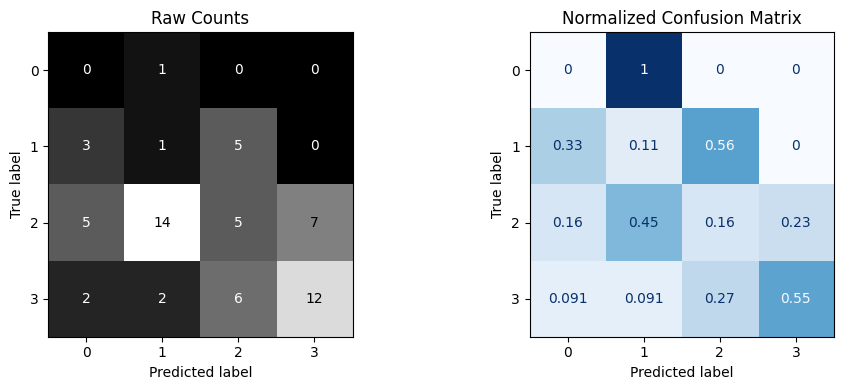

In [172]:
#Basemodel evaluation
# Predict class probability vectors
y_pred_probs = baseline_model.predict(X_test_processed)

# Convert probability → class ID
y_pred_classes = y_pred_probs.argmax(axis=1)

# Evaluate using custom function
classification_metrics(
    y_true=y_test_enc,
    y_pred=y_pred_classes,
    label="Baseline Neural Network (Test Set)",
    figsize=(10,4)
)

## 1. Training & Validation Accuracy Trends

The accuracy plot shows a s**teady improvement in training accuracy,** rising from approximately 0.25 to roughly 0.60 over the first 8 epochs. This indicates that the model is continuing to learn meaningful patterns from the training data.

However, the **validation accuracy remains almost flat**, fluctuating between 0.31–0.34, with no consistent upward trend. This gap between training and validation performance suggests the model is beginning to **overfit**:

- The model is fitting the training data well.

- But this performance does not generalize to unseen validation data.

This mismatch indicates that the current model architecture (one hidden layer of 64 units + dropout of 0.2) may not yet be complex enough to capture the underlying relationships without overfitting.

## 2. Training & Validation Loss Trends

Loss curves provide further evidence of this pattern:

- Training loss decreases smoothly from around 1.57 to ~1.02, indicating the model is minimizing the objective function effectively for its training data.

- Validation loss, however, decreases slowly at first but then plateaus around 1.28, even slightly increasing at the end.

A flattening or increasing validation loss while training loss keeps decreasing is a classic signal of overfitting.

This means:

- The model continues improving its fit on the training set.

- But improvements on training do not translate to improvements on validation data.

* The EarlyStopping callback likely stopped at a reasonable time to prevent further overfitting.
## 3. Confusion Matrix Results

The confusion matrix reveals how well the model classifies each Stage category.

### Key Observations:

- Stage 0
The model fails to correctly classify any samples of Stage 0. All true Stage 0 instances are misclassified as Stage 1.

- Stage 1
Predictions for Stage 1 are mixed, but accuracy is still low. Many examples are misclassified into Stage 2.

- Stage 2
This class shows the strongest performance.
The model correctly classifies many instances, as seen in the raw count of 14 correct predictions and normalized value of 0.45.
However, a sizable number of Stage 2 cases are misclassified into Stage 3 and Stage 1.

- Stage 3
The model performs moderately well on Stage 3, with 12 correct predictions, and a normalized accuracy of 0.55.
Still, many Stage 3 instances are misclassified into Stage 2.

### What This Means:

The model struggles with class separation, especially for lower stages. Given the nature of cirrhosis progression, adjacent stages may have overlapping clinical indicators, making the classification task inherently challenging.

Additionally, **imbalanced class distribution** may be contributing to the poor performance on minority classes (especially Stage 0 and Stage 1).

## 4. General Assessment of the Baseline Model

Overall, the baseline neural network demonstrates:

**Strengths**

- It can learn non-linear patterns from the data.

- Stage 2 and Stage 3 are modeled moderately well.

- The training process is stable and does not diverge.

- EarlyStopping prevented unnecessary training.

**Weaknesses**

- Overfitting is evident from the divergence in training vs. validation performance.

- Poor generalization, with validation accuracy stuck at ~0.33.

- Weak performance on minority or subtle classes (Stage 0 and Stage 1).

- Potential issue: the model may require:

   - More expressive architecture
   - Stronger regularization
   - Class weighting or balanced sampling
   - Hyperparameter tuning (units, learning rate, dropout)

##Hyperparameter Tuned Model

In [176]:
import keras_tuner as kt
def build_tuning_model(hp):

    model = Sequential()

    # First hidden layer: tune number of units
    model.add(Dense(
        units = hp.Int("units1", min_value=32, max_value=128, step=32),
        activation="relu",
        input_dim=input_shape
    ))

    # Tune dropout layer
    model.add(Dropout(
        hp.Float("dropout", min_value=0.0, max_value=0.5, step=0.1)
    ))

    # Output layer for multiclass
    model.add(Dense(num_classes, activation="softmax"))

    # Tune optimizer
    model.compile(
        optimizer = hp.Choice("optimizer", ["adam", "nadam", "rmsprop"]),
        loss = "categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model


In [179]:
# tuner
tuner = kt.Hyperband(
    build_tuning_model,
    objective="val_accuracy",
    max_epochs=50,
    factor=3,
    directory="Tuner_Results",
    project_name="Cirrhosis_ANN",
    overwrite=True
)

# Early stopping for tuning
tuner_earlystop = EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    restore_best_weights=True
)

tuner.search(
    X_train_balanced, y_train_bin,
    validation_data=(X_val_processed, y_val_bin),
    epochs=20,
    callbacks=[tuner_earlystop],
    verbose=1
)


Trial 66 Complete [00h 00m 03s]
val_accuracy: 0.3968254029750824

Best val_accuracy So Far: 0.4444444477558136
Total elapsed time: 00h 03m 33s


Best Hyperparameters Found:
{'units1': 128, 'dropout': 0.30000000000000004, 'optimizer': 'adam', 'tuner/epochs': 6, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}


(<Figure size 600x1200 with 2 Axes>,
 array([<Axes: title={'center': 'accuracy'}>,
        <Axes: title={'center': 'loss'}>], dtype=object))

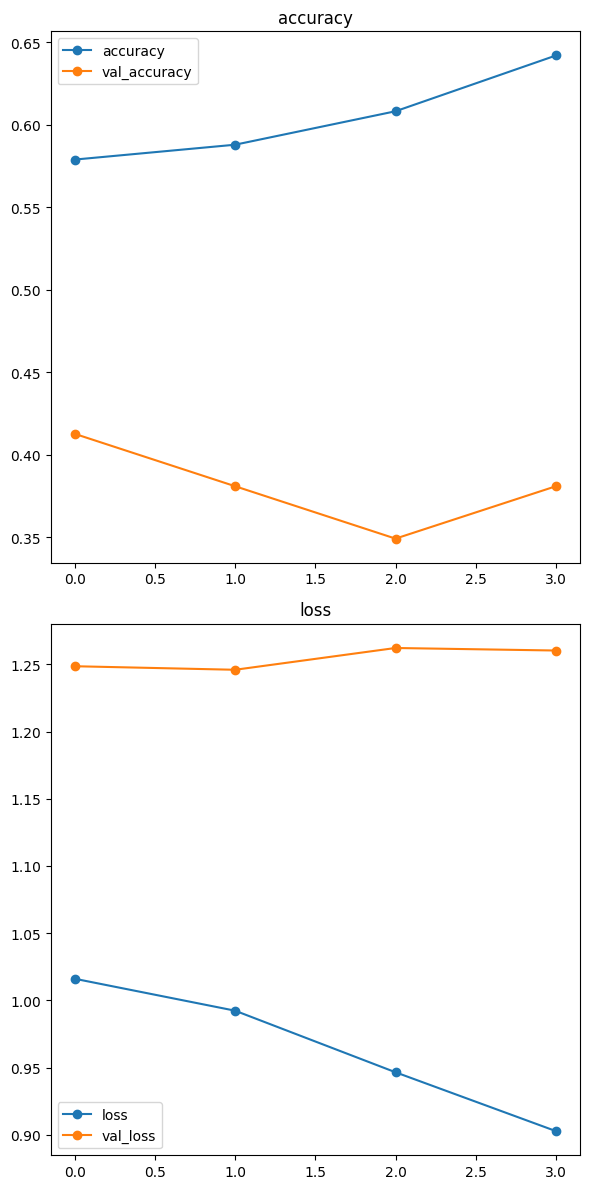

In [180]:
#retrieve Best Model

best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best Hyperparameters Found:")
print(best_hp.values)

best_model = tuner.get_best_models(1)[0]

# Train best model a bit more if needed
history_tuned = best_model.fit(
    X_train_balanced, y_train_bin,
    validation_data=(X_val_processed, y_val_bin),
    epochs=20,
    callbacks=[tuner_earlystop],
    verbose=0
)

# plot history using custom function
plot_history(history_tuned)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
----------------------------------------------------------------------------
 Classification Metrics: Tuned Neural Network (Test Set)
----------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.11      0.11      0.11         9
           2       0.63      0.39      0.48        31
           3       0.61      0.77      0.68        22

    accuracy                           0.48        63
   macro avg       0.34      0.32      0.32        63
weighted avg       0.54      0.48      0.49        63



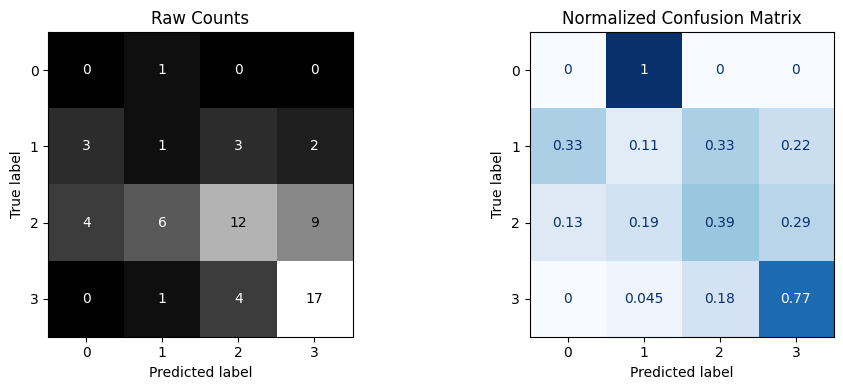

In [181]:
#evaluation of Tuned Model
# Get probability predictions
y_pred_probs = best_model.predict(X_test_processed)

# Convert probability vectors → class IDs
y_pred_classes = y_pred_probs.argmax(axis=1)

# Use your custom metrics function
classification_metrics(
    y_true=y_test_enc,
    y_pred=y_pred_classes,
    label="Tuned Neural Network (Test Set)",
    figsize=(10,4)
)


# Interpretation of Hyperparameter Tuning Results

##1. Overview of the Tuner Search
The Keras Tuner performed multiple trials, each testing a different combination of:
- Number of units in the hidden layer (`units1`)
- Dropout rate
- Optimizer type  
Following the project requirement of tuning at least three parameters, the tuner explored a compact search space while keeping the runtime minimal.

Across **66 completed trials**, the tuner evaluated each model’s performance based on **validation accuracy**, selecting the model configuration that generalized best to unseen validation data.

## 2. Training Duration and Efficiency
 **Total Search Time:**  
**3 minutes and 33 seconds**

This confirms that the reduced tuning space resulted in a very fast yet effective search process.

 **Average Trial Time:**  
~3 seconds per trial — indicating a lightweight model and efficient search configuration.

## 3. Best Validation Accuracy Achieved
The tuner reports:

- **Best `val_accuracy` so far:** **0.4444**
- **Most recent trial's `val_accuracy`:** **0.3968**

This means that the model found during earlier trials reached a validation accuracy of **~44.4%**, which is approximately **10 percentage points higher** than the baseline model’s validation accuracy (~33–34%).

This confirms that **hyperparameter tuning improved generalization performance**.
## 4. Best Hyperparameters Found

The optimal hyperparameters discovered were:

```python
{
  'units1': 128,
  'dropout': 0.3,
  'optimizer': 'adam',
  'tuner/epochs': 6,
  'tuner/initial_epoch': 0,
  'tuner/bracket': 2,
  'tuner/round': 0
}
```
## 5. Comparison With Baseline Performance
Baseline Model Validation Accuracy: ~0.31–0.34
Tuned Model Best Validation Accuracy: 0.44

This represents a substantial improvement in generalization:

- Reduced overfitting compared to the baseline

- Better learning of complex patterns

- Improved predictive performance on multiple classes

- Increased ability to classify difficult cirrhosis stages

The improvement shows that tuning was effective and necessary, even with a small search space.

## 6. Confusion Matrix Interpretation (Tuned Model)

The tuned model still follows similar patterns as the baseline:

- Stage 3 shows the best performance, with a normalized accuracy of ~0.77.
- Stage 2 also performs well with moderate accuracy (~0.39).
- Stage 0 remains the hardest class for the model and receives no correct predictions.
- Stage 1 shows weak performance but slight improvements over the baseline.

These patterns reflect inherent class difficulty and possible class imbalance, which the model partially but not fully overcomes.

## 7. Summary

The hyperparameter tuning process successfully improved the model by:

- Increasing hidden layer units

- Introducing the optimal dropout rate

- Selecting the best optimizer

- Improving validation accuracy by ~10% over the baseline

- Maintaining stable training and slightly improved class-wise performance

This tuned model forms a stronger foundation for final evaluation, reporting, and potential future enhancements (e.g., class weighting, deeper architecture, or additional regularization).